In [2]:
import os
import numpy as np
from collections import defaultdict
import copy

In [8]:
dataset_name = 'FB15k-237'
data_dirs = ['cpg_minerva', 'plain_minerva']
metrics = ['hits_at_1', 'hits_at_3', 'hits_at_5', 'hits_at_10', 'mrr']

In [14]:
# generate the daset paths
def generate_data_paths(dataset_name, data_dirs, metrics, data_type='test'):
    dir_paths = defaultdict(lambda: [].copy())
    for data_dir in data_dirs:
        for metric_type in metrics:
            data_dir_path = os.path.join(os.getcwd(), 
                                         dataset_name, 
                                         data_dir, 
                                         '{}_relation_{}.txt'.format(data_type, metric_type))
            dir_paths[data_dir].append(data_dir_path)
    return dir_paths


def _write_data_to_file(file_path, data):
    if os.path.exists(file_path):
        append_write = 'a'
    else:
        append_write = 'w+'
    with open(file_path, append_write) as handle:
        handle.write(str(data) + "\n")
        

def correct_data_paths(data_dirs):
    for data_dir in data_dirs:
        data_corrected = []
        with open(data_dir, 'r') as handle:
            lines = handle.readlines()
            for idx in range(0, len(lines), 2):
                relation = lines[idx].strip()
                value = lines[idx+1].strip()
                data_corrected.append('{}\t{}'.format(relation, value))
        new_path = data_dir[:-4] + '_new.txt'
        with open(data_dir, 'w') as handle:
            for data in data_corrected:
                handle.write(data + '\n')
            _write_data_to_file(new_path, data)
                

def extract_relation_metrics(paths_dict):
    relation_metrics = defaultdict(lambda: copy.deepcopy({'hits_at_1': [0, 0], 
                                            'hits_at_3': [0, 0], 
                                            'hits_at_5': [0, 0], 
                                            'hits_at_10': [0, 0], 
                                            'mrr': [0, 0]}))
    model_metrics = defaultdict(lambda: relation_metrics.copy())
    
    for model_type in paths_dict.keys():
        for path in paths_dict[model_type]:
            if 'test_relation' in path:
                path_type = path.split('/')[-1][14:-4]
            else:
                path_type = path.split('/')[-1][15:-4]
            with open(path, 'r') as handle:
                for line in handle:
                    relation, metric, total_examples = line.strip().split('\t')
                    model_metrics[model_type][relation][path_type] = [float(metric), total_examples]
    return model_metrics


def cleanly_print_dict(current_object, padding='', precision=3):
    if  (not isinstance(list(current_object.values())[0], dict) and 
         not isinstance(list(current_object.values())[0], defaultdict)):
        for key, value in current_object.items():
            if isinstance(value, list):
                str_value = '{0:.{1}f}'.format(float(value[0]), precision)
                for val_ in value[1:]:
                    str_value += '\t{0}'.format(val_)
            else:
                try:
                    str_value = '{0:.{1}f}'.format(float(value[0]), precision)
                except:
                    str_value = str(value)
            line_to_print = padding + str(key) + '\t' + str_value
            print(line_to_print)
    else:
        for key, value in current_object.items():
            line_to_print = padding + str(key)
            print(line_to_print)
            cleanly_print_dict(value, padding=padding+'\t', precision=precision)
        
        
def sample_from_dict(dictionary, k=10):
    sampled_dict = {}
    relations = dictionary.keys()
    if len(relations) < k:
        k = len(relations)
    sampled_relations = np.random.choice(list(relations), k)
    for sampled_relation in sampled_relations:
        sampled_dict[sampled_relation] = dictionary[sampled_relation]
    return sampled_dict


def compute_ratio(source, target):
    return (target - source) / max(source, 1.)


def compute_metric_differences(model_metrics, source_model, target_model):
    source_model_metrics = model_metrics[source_model]
    target_model_metrics = model_metrics[target_model]
    comparison_metrics = {}
    for relation in source_model_metrics.keys():
        source_relation_metrics = source_model_metrics[relation]
        target_relation_metrics = target_model_metrics[relation]
        comparison_metrics[relation] = {}
        for metric_name in source_relation_metrics.keys():
            source_relation_metric_val = source_relation_metrics[metric_name][0]
            target_relation_metric_val = target_relation_metrics[metric_name][0]
            if metric_name not in comparison_metrics[relation]:
                comparison_metrics[relation][metric_name] = [0, 0]
            comparison_metrics[relation][metric_name][0] = compute_ratio(source_relation_metric_val, 
                                                                         target_relation_metric_val)
            comparison_metrics[relation][metric_name][1] = target_relation_metrics[metric_name][1]
    return comparison_metrics
            

def reorder_metric_storage(metric_storage):
    reodered_storage = {}
    for relation, metrics in metric_storage.items():
        for metric_name, metric_value in metrics.items():
            if metric_name not in reodered_storage.keys():
                reodered_storage[metric_name] = {}
            reodered_storage[metric_name][relation] = metric_value
    return reodered_storage


def sort_dict_by_value(dictionary, decreasing=True, is_list=True):
    if is_list:
        return sorted(dictionary.items(), key=lambda kv: kv[1][0], reverse=decreasing)
    else:
        return sorted(dictionary.items(), key=lambda kv: kv[1], reverse=decreasing)


def get_metric_tails(metric2relation2value, tail_len=10):
    metric_tails_dict = {}
    for metric, relation_metric_values in metric2relation2value.items():
        metric_tails_dict[metric] = {}
        sorted_relation_values = sort_dict_by_value(relation_metric_values, decreasing=True)
        top_k = dict(sorted_relation_values[:tail_len])
        bottom_k = dict(sorted_relation_values[-tail_len:])
        metric_tails_dict[metric]['top_{}'.format(tail_len)] = top_k
        metric_tails_dict[metric]['bottom_{}'.format(tail_len)] = bottom_k
    return metric_tails_dict


def read_entities(dataset_name):
    path = os.path.join(os.getcwd(), dataset_name, 'entities.txt')
    entities = []
    with open(path, 'r') as handle:
        for line in handle:
            entity = line.strip()
            entities.append(entity)
    return entities


def append_data_to_cpg_conve(cpg_conve_path, plain_conve_path, new_path):
    with open(plain_conve_path, 'r') as handle:
        plain_conve_dict = {}
        for line in handle:
            rel, _, num_exp = line.strip().split('\t')
            plain_conve_dict[rel] = num_exp

    with open(cpg_conve_path, 'r') as handle:
        cpg_conve_dict = {}
        for line in handle:
            rel, _ = line.strip().split('\t')
            cpg_conve_dict[rel] = line.strip() + '\t' + plain_conve_dict[rel] + '\n'
    with open(new_path, 'w') as new_path_handle:
        for rel in cpg_conve_dict:
            new_path_handle.write(cpg_conve_dict[rel])

            
def write_metrics_to_file(metrics, dataset_name, model_name, extra_info=None):
    for metric_type, relation_data in metrics.items():
        if extra_info is not None:
            file_name = model_name + '_' + metric_type + '_' + extra_info + '_by_relation.txt'
        else:
            file_name = model_name + '_' + metric_type + '_by_relation.txt'
        file_path = os.path.join(os.getcwd(), dataset_name, file_name)
        with open(file_path, 'w') as handle:
            for relation, values in relation_data.items():
                write_str = '{}\t{}\t{}\t{}\n'.format(relation, values[0], values[1], values[2])
                handle.write(write_str)

                
def num_data_per_relation(file_paths):
    relation_data = {}
    for data_file in file_paths:
        with open(data_file, 'r') as handle:
            for line in handle:
                _, rel, _ = line.strip().split('\t')
                relation_data[rel] = relation_data.get(rel, 0) + 1
    return relation_data


def get_mid2name(examples, mid2name_dict):
    named_examples = []
    for example in examples:
        source_entity = mid2name_dict[example[0]]
        target_entity = mid2name_dict[example[2]]
        named_examples.append((source_entity, example[1], target_entity))
    return named_examples


def combine_dict_info(dict1, dict2, has_topk=False):
    joined_dict = {}
    for metric_name in dict1:
        joined_dict[metric_name] = {}
        if has_topk:
            for top_k in dict1[metric_name]:
                joined_dict[metric_name][top_k] = {}
                for relation in dict1[metric_name][top_k]:
                    dict1_value = dict1[metric_name][top_k][relation]
                    dict2_value = dict2[relation]
                    joined_dict[metric_name][top_k][relation] = dict1_value + [dict2_value]
        else:
            for relation in dict1[metric_name]:
                dict1_value = dict1[metric_name][relation]
                dict2_value = dict2[relation]
                joined_dict[metric_name][relation] = dict1_value + [dict2_value]
    return joined_dict
    

In [126]:
append_data_to_cpg_conve(metric_dir_paths['cpg_conve'][4], metric_dir_paths['plain_conve'][4],
'/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/cpg_conve/test_relation_mrr.txt')

In [9]:
metric_dir_paths = generate_data_paths(dataset_name, data_dirs, metrics, data_type='test')
metric_dir_paths

defaultdict(<function __main__.generate_data_paths.<locals>.<lambda>>,
            {'cpg_minerva': ['/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/cpg_minerva/test_relation_hits_at_1.txt',
              '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/cpg_minerva/test_relation_hits_at_3.txt',
              '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/cpg_minerva/test_relation_hits_at_5.txt',
              '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/cpg_minerva/test_relation_hits_at_10.txt',
              '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/cpg_minerva/test_relation_mrr.txt'],
             'plain_minerva': ['/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/plain_minerva/test_relation_hits_at_1.txt',
              '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/plain_minerva/tes

In [10]:
print(metric_dir_paths['cpg_minerva'][4])
print(metric_dir_paths['plain_minerva'][4])

/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/cpg_minerva/test_relation_mrr.txt
/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/plain_minerva/test_relation_mrr.txt


In [103]:
# if metrics are messed up run this
# correct_data_paths(metric_dir_paths['cpg_conve'])

In [11]:
model_metrics = extract_relation_metrics(metric_dir_paths)

In [12]:
sampled_dictionary = sample_from_dict(model_metrics)

In [15]:
cleanly_print_dict(sampled_dictionary)

plain_minerva
	/location/administrative_division/country
		hits_at_1	0.667	3.0
		hits_at_3	0.667	3.0
		hits_at_10	0.667	3.0
		mrr	0.688	3.0
		hits_at_5	0.667	3.0
	/broadcast/content/artist
		hits_at_1	0.000	14.0
		hits_at_3	0.000	14.0
		hits_at_10	0.000	14.0
		mrr	0.008	14.0
		hits_at_5	0.000	14.0
	/people/profession/specialization_of
		hits_at_1	0.000	13.0
		hits_at_3	0.077	13.0
		hits_at_10	0.154	13.0
		mrr	0.062	13.0
		hits_at_5	0.154	13.0
	/dataworld/gardening_hint/split_to
		hits_at_1	0.000	10.0
		hits_at_3	0.100	10.0
		hits_at_10	0.300	10.0
		mrr	0.082	10.0
		hits_at_5	0.100	10.0
	/film/film/distributors./film/film_film_distributor_relationship/film_distribution_medium
		hits_at_1	0.316	38.0
		hits_at_3	0.842	38.0
		hits_at_10	0.947	38.0
		mrr	0.591	38.0
		hits_at_5	0.921	38.0
	/education/university/fraternities_and_sororities
		hits_at_1	0.571	21.0
		hits_at_3	0.905	21.0
		hits_at_10	0.952	21.0
		mrr	0.744	21.0
		hits_at_5	0.905	21.0
	/organization/endowed_organization/endowment

In [63]:
reoredered_model_metrics = reorder_metric_storage(model_metrics['cpg_minerva'])

In [64]:
tail_model_metrics = get_metric_tails(reoredered_model_metrics, tail_len=10)

In [65]:
cleanly_print_dict(tail_model_metrics)

hits_at_1
	top_10
		/base/biblioness/bibs_location/state	1.000 | 7.0
		/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency	1.000 | 46.0
		/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type	1.000 | 22.0
		/sports/sports_team/roster./baseball/baseball_roster_position/position	1.000 | 3.0
		/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency	1.000 | 22.0
		/business/business_operation/revenue./measurement_unit/dated_money_value/currency	1.000 | 1.0
		/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source	1.000 | 84.0
		/organization/endowed_organization/endowment./measurement_unit/dated_money_value/currency	1.000 | 3.0
		/education/university/local_tuition./measurement_unit/dated_money_value/currency	1.000 | 1.0
		/film/film/distributors./film/film_film_distributor_relationship/region	1.000 | 10.0
	bottom_10
		/base/popstra/location/vacat

In [66]:
cleanly_print_dict({'hits_at_1': tail_model_metrics['hits_at_1']})

hits_at_1
	top_10
		/base/biblioness/bibs_location/state	1.000 | 7.0
		/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency	1.000 | 46.0
		/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type	1.000 | 22.0
		/sports/sports_team/roster./baseball/baseball_roster_position/position	1.000 | 3.0
		/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency	1.000 | 22.0
		/business/business_operation/revenue./measurement_unit/dated_money_value/currency	1.000 | 1.0
		/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source	1.000 | 84.0
		/organization/endowed_organization/endowment./measurement_unit/dated_money_value/currency	1.000 | 3.0
		/education/university/local_tuition./measurement_unit/dated_money_value/currency	1.000 | 1.0
		/film/film/distributors./film/film_film_distributor_relationship/region	1.000 | 10.0
	bottom_10
		/base/popstra/location/vacat

In [67]:
list(model_metrics['cpg_minerva'].keys())

['/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type',
 '/education/educational_degree/people_with_this_degree./education/education/student',
 '/base/x2010fifaworldcupsouthafrica/world_cup_squad/current_world_cup_squad./base/x2010fifaworldcupsouthafrica/current_world_cup_squad/current_club',
 '/film/film/dubbing_performances./film/dubbing_performance/actor',
 '/award/award_winning_work/awards_won./award/award_honor/award',
 '/influence/influence_node/influenced_by',
 '/business/job_title/people_with_this_title./business/employment_tenure/company',
 '/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language',
 '/people/person/place_of_birth',
 '/award/award_category/category_of',
 '/base/popstra/celebrity/canoodled./base/popstra/canoodled/participant',
 '/film/film/personal_appearances./film/personal_film_appearance/person',
 '/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy',
 '/fil

In [129]:
minerva_metric_diffs = compute_metric_differences(model_metrics, 'plain_minerva', 'cpg_minerva')

In [130]:
minerva_metrics_reordered = reorder_metric_storage(minerva_metric_diffs)

In [131]:
minerva_tail_model_metrics = get_metric_tails(minerva_metrics_reordered, tail_len=10)

In [132]:
cleanly_print_dict(minerva_tail_model_metrics['hits_at_10'])

top_10
	/government/politician/government_positions_held./government/government_position_held/legislative_sessions	0.500 	 30.0
	/film/film/film_art_direction_by	0.667 	 3.0
	/film/film/film_festivals	0.556 	 18.0
	/base/eating/practicer_of_diet/diet	1.000 	 11.0
	/film/person_or_entity_appearing_in_film/films./film/personal_film_appearance/type_of_appearance	1.000 	 3.0
	/tv/tv_producer/programs_produced./tv/tv_producer_term/program	0.500 	 4.0
	/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month	0.533 	 60.0
	/sports/sports_team/roster./american_football/football_historical_roster_position/position_s	1.000 	 1.0
	/location/us_county/county_seat	0.500 	 2.0
	/award/award_winning_work/awards_won./award/award_honor/honored_for	0.700 	 10.0
bottom_10
	/influence/influence_node/peers./influence/peer_relationship/peers	-0.500 	 2.0
	/people/ethnicity/geographic_distribution	-0.118 	 17.0
	/film/film_set_designer/film_sets_designed	-0.125 	 8.0
	/tv/tv_person

In [133]:
conve_metric_diffs = compute_metric_differences(model_metrics, 'plain_conve', 'cpg_conve')

In [134]:
conve_metrics_reordered = reorder_metric_storage(conve_metric_diffs)

In [135]:
conve_tail_model_metrics = get_metric_tails(conve_metrics_reordered, tail_len=10)

In [141]:
cleanly_print_dict(conve_tail_model_metrics['mrr'])

top_10
	/user/jg/default_domain/olympic_games/sports	0.404 	 11
	/award/award_nominated_work/award_nominations./award/award_nomination/nominated_for	0.244 	 16
	/education/educational_institution/campuses	0.573 	 13
	/sports/sports_team/roster./american_football/football_roster_position/position	0.418 	 3
	/education/educational_institution_campus/educational_institution	0.537 	 13
	/location/hud_county_place/place	0.710 	 48
	/music/instrument/family	0.304 	 6
	/tv/tv_producer/programs_produced./tv/tv_producer_term/program	0.328 	 4
	/location/us_county/county_seat	0.466 	 2
	/dataworld/gardening_hint/split_to	0.340 	 10
bottom_10
	/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/contact_category	-0.075 	 20
	/base/marchmadness/ncaa_basketball_tournament/seeds./base/marchmadness/ncaa_tournament_seed/team	-0.118 	 41
	/location/statistical_region/gdp_nominal_per_capita./measurement_unit/dated_money_value/currency	-0.167 	 3
	/sports/sports_league_dr

# Data Parsing

In [90]:
data_dir = 'FB15k-237'
data_files = ['train.txt']
file_paths = [os.path.join(os.getcwd(), data_dir, data_dir, data_file) for data_file in data_files]

In [427]:
rel_props_in_data = num_data_per_relation(file_paths)

In [540]:
cleanly_print_dict(rel_props_in_data)

/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type	225
/business/business_operation/assets./measurement_unit/dated_money_value/currency	181
/education/educational_degree/people_with_this_degree./education/education/student	260
/base/x2010fifaworldcupsouthafrica/world_cup_squad/current_world_cup_squad./base/x2010fifaworldcupsouthafrica/current_world_cup_squad/current_club	246
/film/film/dubbing_performances./film/dubbing_performance/actor	114
/music/record_label/artist	2226
/influence/influence_node/influenced_by	1908
/business/job_title/people_with_this_title./business/employment_tenure/company	734
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language	208
/people/person/place_of_birth	2465
/award/award_category/category_of	148
/base/popstra/celebrity/canoodled./base/popstra/canoodled/participant	449
/film/film/personal_appearances./film/personal_film_appearance/person	217
/user/tsegaran/random/taxonomy_subject/entry./us

In [246]:
minerva_tail_metrics_all = combine_dict_info(minerva_tail_model_metrics, rel_props_in_data)

In [254]:
conve_tail_metrics_all = combine_dict_info(conve_tail_model_metrics, rel_props_in_data)

In [761]:
cleanly_print_dict_(conve_tail_metrics_all['hits_at_1'])

top_10
	/user/jg/default_domain/olympic_games/sports	0.455	11	581
	/education/educational_institution/campuses	0.692	13	533
	/sports/sports_team/roster./american_football/football_roster_position/position	0.667	3	607
	/education/educational_institution_campus/educational_institution	0.769	13	526
	/education/university/domestic_tuition./measurement_unit/dated_money_value/currency	0.400	5	476
	/location/hud_county_place/place	0.896	48	459
	/music/instrument/family	0.333	6	100
	/government/politician/government_positions_held./government/government_position_held/legislative_sessions	0.333	30	215
	/soccer/football_team/current_roster./soccer/football_roster_position/position	0.300	10	2265
	/organization/endowed_organization/endowment./measurement_unit/dated_money_value/currency	0.333	3	456
bottom_10
	/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/contact_category	-0.150	20	142
	/base/marchmadness/ncaa_basketball_tournament/seeds./base/marchmadness/nca

In [264]:
rel_props_in_data_sorted = sort_dict_by_value(rel_props_in_data, is_list=False)

In [269]:
rel_props_in_data_sorted

[('/award/award_nominee/award_nominations./award/award_nomination/award_nominee',
  15989),
 ('/film/film/release_date_s./film/film_regional_release_date/film_release_region',
  12893),
 ('/award/award_nominee/award_nominations./award/award_nomination/award',
  12157),
 ('/people/person/profession', 10945),
 ('/film/actor/film./film/performance/film', 9494),
 ('/award/award_category/nominees./award/award_nomination/nominated_for',
  9465),
 ('/award/award_winner/awards_won./award/award_honor/award_winner', 8423),
 ('/film/film/genre', 7268),
 ('/award/award_nominee/award_nominations./award/award_nomination/nominated_for',
  6277),
 ('/music/genre/artists', 5880),
 ('/award/award_category/winners./award/award_honor/award_winner', 5673),
 ('/film/film/other_crew./film/film_crew_gig/film_crew_role', 5305),
 ('/location/location/contains', 5201),
 ('/people/person/nationality', 4197),
 ('/music/performance_role/track_performances./music/track_contribution/role',
  3795),
 ('/people/person/

## Visualize Relation Hierarchy

In [318]:
def create_depth_hierarchy(dict_level, depth_map):
    value_map = dict_level

    for depth_level in depth_map[:-2]:
        if depth_level not in value_map:
            value_map[depth_level] = {}
        value_map = value_map[depth_level]
    
    penultimate_level = depth_map[-2]
    last_level = depth_map[-1]
    if penultimate_level not in value_map:
        value_map[penultimate_level] = set() 
    value_map[penultimate_level].add(last_level)
    
    return dict_level

def generate_relation_hierarchy(relation_set):
    relation_hierarchy = {}
    relation_hierarchy['.'] = {}
    
    value_map = relation_hierarchy['.']
    
    for relation in relation_set:
        if '.' in relation:
            source, target = relation.strip().split('.')
            source_types = source.split('/')
            target_types = target.split('/')
            
            create_depth_hierarchy(value_map, source_types)
            create_depth_hierarchy(value_map, target_types)
        else:
            types = relation.strip().split('/')
            create_depth_hierarchy(value_map, types)
    return value_map

def traverse_tree_depth(tree, path_dict):
    print(path_dict)
    if isinstance(list(path_dict.values())[0], set):
        for key, values in path_dict.items():
            for value in values:
                tree.create_node(value, parent=key)
    else:
        for key, value in path_dict.items():
            for sub_key in value.keys():
                tree.create_node(sub_key, parent=key)
                traverse_tree_depth(tree, {sub_key: value[sub_key]})

def create_tree_from_hierarchy(hierarchy):
    from treelib import Node, Tree
    tree = Tree()
    tree.create_node('', '')
    traverse_tree_depth(tree, hierarchy) 


In [287]:
relation_set = set(list(rel_props_in_data.keys()))
relation_hierarchy = generate_relation_hierarchy(relation_set)

In [382]:
relation_hierarchy

{'': {'american_football': {'football_historical_roster_position': {'position_s'},
   'football_roster_position': {'position'},
   'football_team': {'current_roster'}},
  'award': {'award_category': {'category_of',
    'disciplines_or_subjects',
    'nominees',
    'winners'},
   'award_ceremony': {'awards_presented'},
   'award_honor': {'award', 'award_winner', 'ceremony', 'honored_for'},
   'award_nominated_work': {'award_nominations'},
   'award_nomination': {'award', 'award_nominee', 'nominated_for'},
   'award_nominee': {'award_nominations'},
   'award_winner': {'awards_won'},
   'award_winning_work': {'awards_won'},
   'hall_of_fame': {'inductees'},
   'hall_of_fame_induction': {'inductee'},
   'ranked_item': {'appears_in_ranked_lists'},
   'ranking': {'list'}},
  'base': {'aareas': {'schema': {'administrative_area': {'administrative_area_type',
      'administrative_parent',
      'capital'}}},
   'americancomedy': {'celebrity_impressionist': {'celebrities_impersonated'}},
   'b

In [377]:
from treelib import Tree, Node
def traverse_tree_depth(tree, path_dict):
    # print(path_dict)
    if isinstance(list(path_dict.values())[0], set):
        for key, values in path_dict.items():
            for value in values:
                value_node = Node(value)
                tree.add_node(value_node, parent=key)
                # tree.create_node(value, parent=key)
    else:
        for key, value in path_dict.items():
            for sub_key in value.keys():
                sub_key_node = Node(sub_key)
                tree.add_node(sub_key_node, parent=key)
                # tree.create_node(sub_key_node, parent=key)
                traverse_tree_depth(tree, {sub_key_node: value[sub_key]})


def create_tree_from_hierarchy(hierarchy):
    tree = Tree()
    root = Node('.')
    # tree.create_node('.', '.')
    tree.add_node(root)
    traverse_tree_depth(tree, {root: hierarchy})
    return tree
    
relation_tree = create_tree_from_hierarchy(relation_hierarchy)

In [381]:
tree_file = os.path.join(os.getcwd(), dataset_name, 'relation_tree.txt')
print(relation_tree.show(), open(tree_file, 'a'))

.
└── 
    ├── american_football
    │   ├── football_historical_roster_position
    │   │   └── position_s
    │   ├── football_roster_position
    │   │   └── position
    │   └── football_team
    │       └── current_roster
    ├── award
    │   ├── award_category
    │   │   ├── category_of
    │   │   ├── disciplines_or_subjects
    │   │   ├── nominees
    │   │   └── winners
    │   ├── award_ceremony
    │   │   └── awards_presented
    │   ├── award_honor
    │   │   ├── award
    │   │   ├── award_winner
    │   │   ├── ceremony
    │   │   └── honored_for
    │   ├── award_nominated_work
    │   │   └── award_nominations
    │   ├── award_nomination
    │   │   ├── award
    │   │   ├── award_nominee
    │   │   └── nominated_for
    │   ├── award_nominee
    │   │   └── award_nominations
    │   ├── award_winner
    │   │   └── awards_won
    │   ├── award_winning_work
    │   │   └── awards_won
    │   ├── hall_of_fame
    │   │   └── inductees
    │   ├── hall_of_fame_ind

In [680]:
def break_relation_into_parts(relation):
    if '.' in relation:
        source, target = relation.strip().split('.')
        source_parts = source.split('/')
        target_parts = target.split('/')
    else:
        source_parts = []
        target_parts = relation.strip().split('/')

    return {'source': source_parts, 'target': target_parts}


def get_similarity_paths(base_path, level_data, paths_set): 
    if isinstance(level_data, set):
        for data in level_data:
            new_path = base_path + '/{}'.format(data)
            paths_set.add(new_path)
    else:
        # level is dict
        for key, values in level_data.items():

            get_similarity_paths(base_path + '/{}'.format(key), values, paths_set)
    
    return paths_set


def find_similar_relation_parts(relation_hierarchy, part_query):
    search_level = copy.deepcopy(relation_hierarchy)
    for part in part_query:
        search_level = search_level[part]
        
    similar_parts = set()
    
    if len(part_query) > 0:
        path_query = '/'.join(part_query)
        similar_parts = get_similarity_paths(path_query, search_level, similar_parts)

    return similar_parts


def combine_valid_relation_parts(relation_set, source_parts, target_parts):
    valid_relations = set()
    for target_part in target_parts:
        for source_part in source_parts:
            potential_relation = source_part + '.' + target_part
            if potential_relation in relation_set:
                valid_relations.add(potential_relation)
        if len(source_parts) == 0 and target_part in relation_set:
            valid_relations.add(target_part)
    return valid_relations


def extract_similar_relations(relation_info, query_relation, source_degree=1, target_degree=1, remove_query_rel=False):
    relation_hierarchy = relation_info['hierarchy']
    relation_data = relation_info['data']
    
    parts = break_relation_into_parts(query_relation)
    source_part, target_part = parts['source'], parts['target']

    source_part = source_part[:len(source_part)-source_degree]
    target_part = target_part[:len(target_part)-target_degree]
    
    all_source_parts = find_similar_relation_parts(relation_hierarchy, source_part)
    all_target_parts = find_similar_relation_parts(relation_hierarchy, target_part)
    similar_relations = combine_valid_relation_parts(set(list(relation_data.keys())), 
                                                     all_source_parts, 
                                                     all_target_parts)
    if remove_query_rel:
        similar_relations.remove(query_relation)
    return similar_relations
    

def aggregate_group_data(relation_data, group, metric='mean'):
    data = []
    if isinstance(group, tuple):
        query_relation, group = group
        query_value = relation_data[query_relation]
    else:
        query_relation= None
        
    for relation in group:
        value = relation_data[relation]
        data.append(value)
    if metric == 'mean':
        metric_value = np.mean(data) if len(data) > 0 else 0.0
    elif metric =='sum':
        metric_value = np.sum(data)
    elif metric == 'prop':
        metric_value =  query_value / max(np.sum(data), 1.)
    else:
        raise("Metric not found. Please specify 'mean' or 'sum'.")
    
    return metric_value
    
def sanity_check_relations(degree_path, relations):
    all_relations = set()
    for relation in relations:
        rel_split = relation.split('.')
        if len(rel_split) > 1:
            rel_source, rel_target = rel_split
        else:
            rel_source = ''
            rel_target = rel_split
        if degree_path in rel_source and degree_path in rel_target:
            all_relations.add(relation)
    return relation


def find_relations_similarity_metrics(relations, relation_info, source_degree=1,target_degree=1, 
                                      metric='mean', remove_query_rel=False, do_prop=True):
    metric_dict = {}
    relation_data = relation_info['data']
    for relation in relations:
#         print(relation)
        similar_relations = extract_similar_relations(relation_info=relation_info, 
                                                      query_relation=relation,
                                                      source_degree=source_degree, 
                                                      target_degree=target_degree, 
                                                      remove_query_rel=remove_query_rel)
        if do_prop:
            similar_relations = (relation, similar_relations)
        metric_value = aggregate_group_data(relation_data, similar_relations, metric=metric)
        metric_dict[relation] = metric_value
    return metric_dict

In [737]:
def test_get_similar_relations(relation_hierarchy, relation_set):
    relation_parts_set = {}
    for relation in relation_set:
        if '.' in relation:
            source, target = relation.strip().split('.')
            relation_parts_set[source] = 0
            relation_parts_set[target] = 0
        else:
            relation_parts_set[relation.strip()] = 0
    
    for top_level in relation_hierarchy['']:
        similar_relations_set = find_similar_relation_parts(relation_hierarchy, ['', top_level])
        for relation in similar_relations_set:
            if relation not in relation_parts_set:
                raise('Relation: {} not in relation parts! | Top level: {}'.format(relation, top_level))
            else:
                relation_parts_set[relation] += 1
    if 0 in list(relation_parts_set.values()):
        raise('Error: Relation parts under represented')
    print('Passed!')

In [738]:
test_get_similar_relations(relation_hierarchy, list(rel_props_in_data.keys()))

Passed!


# Extract Degree Similarity Metrics

In [725]:
query_relation = '/travel/travel_destination/how_to_get_here./travel/transportation/mode_of_transportation'
relation_parts = break_relation_into_parts(query_relation)
source_parts, target_parts = relation_parts['source'], relation_parts['target']
source_degree = 1
target_degree = 1
print(source_parts)
print(target_parts)

['', 'travel', 'travel_destination', 'how_to_get_here']
['', 'travel', 'transportation', 'mode_of_transportation']


In [607]:
find_similar_relation_parts(relation_hierarchy, source_parts[:len(source_parts) - source_degree])

{'/travel/transportation/mode_of_transportation',
 '/travel/travel_destination/climate',
 '/travel/travel_destination/how_to_get_here',
 '/travel/travel_destination_monthly_climate/month'}

In [608]:
similar_sources = find_similar_relation_parts(relation_hierarchy, source_parts[:len(source_parts) - source_degree])
similar_targets = find_similar_relation_parts(relation_hierarchy, target_parts[:len(target_parts) - target_degree])

In [609]:
relation_hierarchy['']['travel']['transportation']

{'mode_of_transportation'}

In [610]:
similar_sources

{'/travel/transportation/mode_of_transportation',
 '/travel/travel_destination/climate',
 '/travel/travel_destination/how_to_get_here',
 '/travel/travel_destination_monthly_climate/month'}

In [611]:
similar_targets

{'/travel/transportation/mode_of_transportation',
 '/travel/travel_destination/climate',
 '/travel/travel_destination/how_to_get_here',
 '/travel/travel_destination_monthly_climate/month'}

In [710]:
group = extract_similar_relations(relation_info={'hierarchy': relation_hierarchy,
                                                 'data': rel_props_in_data},
                                  query_relation=query_relation,
                                  source_degree=1,
                                  target_degree=2)
group

{'/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month',
 '/travel/travel_destination/how_to_get_here./travel/transportation/mode_of_transportation'}

In [723]:
x =(rel_props_in_data['/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month'])
y = (rel_props_in_data['/travel/travel_destination/how_to_get_here./travel/transportation/mode_of_transportation'])
y / (x + y)

0.2143906020558003

True

In [722]:
aggregate_group_data(rel_props_in_data, (query_relation, group), metric='prop')

0.2143906020558003

In [762]:
relation_info={'hierarchy': relation_hierarchy, 'data': rel_props_in_data}
source_degree, target_degree = 1, 1
relation_metrics = find_relations_similarity_metrics(relation_info=relation_info, 
                                                     relations=set(list(rel_props_in_data.keys())), 
                                                     source_degree=source_degree, 
                                                     target_degree=target_degree, 
                                                     metric='mean', 
                                                     do_prop=True,
                                                     remove_query_rel=False)

In [697]:
cleanly_print_dict(relation_metrics)

/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type	0.35101404056162244
/film/film/costume_design_by	0.008614887602638309
/business/business_operation/assets./measurement_unit/dated_money_value/currency	0.3047138047138047
/education/educational_degree/people_with_this_degree./education/education/student	0.08635004981733643
/base/aareas/schema/administrative_area/administrative_parent	0.6639908256880734
/base/x2010fifaworldcupsouthafrica/world_cup_squad/current_world_cup_squad./base/x2010fifaworldcupsouthafrica/current_world_cup_squad/current_club	1.0
/film/film/dubbing_performances./film/dubbing_performance/actor	0.005373049912805769
/organization/role/leaders./organization/leadership/organization	1.0
/award/award_winning_work/awards_won./award/award_honor/award	0.4884167035561458
/influence/influence_node/influenced_by	1.0
/base/eating/practicer_of_diet/diet	1.0
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language	0.29

In [763]:
dict_to_use = relation_metrics

In [764]:
conve_metrics_all = combine_dict_info(conve_metrics_reordered, dict_to_use)

In [765]:
minerva_metrics_all = combine_dict_info(minerva_metrics_reordered, dict_to_use)

In [618]:
write_metrics_to_file(conve_metrics_all, dataset_name, 'conve', extra_info='degree{}'.format(source_degree))

In [620]:
write_metrics_to_file(minerva_metrics_all, dataset_name, 'minerva', extra_info='degree{}'.format(source_degree))

In [621]:
sort_dict_by_value(conve_metrics_all['hits_at_1'])

[('/location/hud_county_place/place', [0.8958333333333334, '48', 382.0]),
 ('/education/educational_institution_campus/educational_institution',
  [0.7692307692307692, '13', 526.0]),
 ('/education/educational_institution/campuses',
  [0.6923076923076923, '13', 705.6666666666666]),
 ('/sports/sports_team/roster./american_football/football_roster_position/position',
  [0.6666666666666666, '3', 607.0]),
 ('/user/jg/default_domain/olympic_games/sports',
  [0.45454545454545453, '11', 581.0]),
 ('/education/university/domestic_tuition./measurement_unit/dated_money_value/currency',
  [0.4, '5', 317.6666666666667]),
 ('/organization/endowed_organization/endowment./measurement_unit/dated_money_value/currency',
  [0.33333333333333337, '3', 456.0]),
 ('/government/politician/government_positions_held./government/government_position_held/legislative_sessions',
  [0.33333333333333337, '30', 145.0]),
 ('/music/instrument/family', [0.3333333333333333, '6', 1019.0]),
 ('/soccer/football_team/current_r

# Visualize Metrics

In [705]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.5/site-packages/t

In [767]:
def compute_relation_ids(relation_dict):
    rel2id = {}
    sorted_list = sort_dict_by_value(relation_dict, is_list=True, decreasing=True)
    for idx, tuple_values in enumerate(sorted_list):
        relation, _ = tuple_values
        rel2id[relation] = idx
    return rel2id


def moving_average(a, n, same=True):
    n = min(n, len(a))
    cumsum = np.cumsum(a, dtype=float)
    if same:
        result = np.zeros((len(a),), dtype=np.float32)
        # Return same size.
        for i in range(0, n):
            result[i] = cumsum[i] / float(i+1)
        result[n:] = (cumsum[n:] - cumsum[:-n]) / n
        return result
    return cumsum[n - 1:] / n


def plot_relation_metrics(relation_metrics, plot_name='ConvE Hits@1 Differences'):
    rel2id = compute_relation_ids(relation_metrics)
    x_values = []
    metric_values = []
    num_examples = []
    relation_ordered = []
    for relation, values in relation_metrics.items():
        rel_id = rel2id[relation]
        relation_ordered.append(relation)
        metric_value = values[0]
        num_example = values[2]
        
        x_values.append(rel_id)
        metric_values.append(metric_value)
        num_examples.append(num_example)
    
    # sort data by x value
    x_values = np.array(x_values)
    metric_values = np.array(metric_values)
    num_examples = np.array(num_examples)
    relation_ordered = np.array(relation_ordered)
    
    x_idxs = np.argsort(x_values)
    x_values = x_values[x_idxs]
    metric_values = metric_values[x_idxs]
    num_examples = num_examples[x_idxs]
    relation_ordered = relation_ordered[x_idxs]
    
    metric_values = moving_average(metric_values, 40)
    num_examples = moving_average(num_examples, 40)
    
    fig, ax1 = plt.subplots()

    color = 'tab:green'
    ax1.set_xlabel('relation ids')
    ax1.set_ylabel('Performance Gain', color=color)
    ax1.plot(x_values, metric_values, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Num Training', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_values, num_examples, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    return relation_ordered 

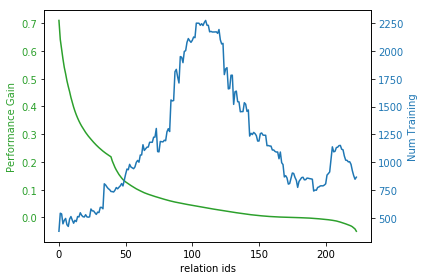

In [768]:
%matplotlib inline
relations_ordered = plot_relation_metrics(conve_metrics_all['mrr'])

In [740]:
len(relation_hierarchy[''].keys())

32

In [770]:
for i, rel in enumerate(relations_ordered):
    print(i, rel)

0 /location/hud_county_place/place
1 /education/educational_institution/campuses
2 /education/educational_institution_campus/educational_institution
3 /location/us_county/county_seat
4 /sports/sports_team/roster./american_football/football_roster_position/position
5 /user/jg/default_domain/olympic_games/sports
6 /dataworld/gardening_hint/split_to
7 /tv/tv_producer/programs_produced./tv/tv_producer_term/program
8 /music/instrument/family
9 /award/award_nominated_work/award_nominations./award/award_nomination/nominated_for
10 /influence/influence_node/peers./influence/peer_relationship/peers
11 /government/politician/government_positions_held./government/government_position_held/legislative_sessions
12 /people/ethnicity/geographic_distribution
13 /education/university/domestic_tuition./measurement_unit/dated_money_value/currency
14 /film/film/produced_by
15 /base/biblioness/bibs_location/country
16 /film/film/executive_produced_by
17 /medicine/disease/risk_factors
18 /location/country/se

In [781]:
dictionary = conve_metrics_all['mrr']
rel_ranked = dict(list(map(lambda key: (key, dictionary[key][2]), dictionary.keys())))
rel_ranked = sort_dict_by_value(rel_ranked, is_list=False)
for idx, (rel, val) in enumerate(rel_ranked):
    print(idx, val, rel)

0 11474.333333333334 /award/award_nominee/award_nominations./award/award_nomination/award_nominee
1 11474.333333333334 /award/award_nominee/award_nominations./award/award_nomination/award
2 11474.333333333334 /award/award_nominee/award_nominations./award/award_nomination/nominated_for
3 9465.0 /award/award_category/nominees./award/award_nomination/nominated_for
4 8423.0 /award/award_winner/awards_won./award/award_honor/award_winner
5 4856.0 /film/film/release_date_s./film/film_regional_release_date/film_regional_debut_venue
6 4856.0 /film/film/release_date_s./film/film_regional_release_date/film_release_region
7 4856.0 /film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
8 4837.0 /film/actor/film./film/performance/special_performance_type
9 4837.0 /film/actor/film./film/performance/film
10 4253.5 /award/award_category/winners./award/award_honor/ceremony
11 4253.5 /award/award_category/winners./award/award_honor/award_winner
12 3865.3333333333335 /

In [744]:
for i, pair in enumerate(rel_props_in_data_sorted):
    print(i, pair[1], pair[0])

0 15989 /award/award_nominee/award_nominations./award/award_nomination/award_nominee
1 12893 /film/film/release_date_s./film/film_regional_release_date/film_release_region
2 12157 /award/award_nominee/award_nominations./award/award_nomination/award
3 10945 /people/person/profession
4 9494 /film/actor/film./film/performance/film
5 9465 /award/award_category/nominees./award/award_nomination/nominated_for
6 8423 /award/award_winner/awards_won./award/award_honor/award_winner
7 7268 /film/film/genre
8 6277 /award/award_nominee/award_nominations./award/award_nomination/nominated_for
9 5880 /music/genre/artists
10 5673 /award/award_category/winners./award/award_honor/award_winner
11 5305 /film/film/other_crew./film/film_crew_gig/film_crew_role
12 5201 /location/location/contains
13 4197 /people/person/nationality
14 3795 /music/performance_role/track_performances./music/track_contribution/role
15 3738 /people/person/places_lived./people/place_lived/location
16 3717 /people/person/gender
17 36

# mid to Entity name dump and transformation!

In [818]:
test_file = '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/FB15k-237/test.txt'
train_file = '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/FB15k-237/FB15k-237/train.txt'
files2read = [test_file]
mid2name_path = '/Users/georgestoica/Desktop/mid2name.txt'

In [808]:
def get_data_from_files(files, mid2name_dict):
    relation_data = {}
    missed_entities = set()
    for file in files:
        with open(file, 'r') as handle:
            for line in handle:
                e1, rel, e2 = line.strip().split('\t')
                if rel not in relation_data:
                    relation_data[rel] = {'e1': set(), 'e2': set()}
                    
                if e1 not in mid2name_dict:
                    missed_entities.add(e1)
                else:
                    e1 = mid2name_dict[e1]
                    relation_data[rel]['e1'].add(e1)
                
                if e2 not in mid2name_dict:
                    missed_entities.add(e2)
                else:
                    e2 = mid2name_dict[e2]
                    relation_data[rel]['e2'].add(e2)
    
    return relation_data, missed_entities

def read_mid2name(mid2name_path):
    mid2name = {}
    with open(mid2name_path, 'r', encoding="utf-8") as handle:
        for line in handle:
            try:
                mid, entity = line.strip().split('\t')
            except:
                continue
            mid2name[mid] = entity
    return mid2name

In [805]:
mid2name = read_mid2name(mid2name_path)

In [819]:
named_rel_test_data, missed_test_entities = get_data_from_files(files2read, mid2name)
named_rel_train_data, missed_train_entities = get_data_from_files([train_file], mid2name)

In [817]:
cleanly_print_dict(named_rel_test_data)

/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
	e2	{'Artistic producer'}
	e1	{'Gary Marshall', 'Buck Henry', 'Sydney sheldon', 'Tom Werner', 'Craig Thomas (screenwriter)', 'Matthew Richard Stone', 'Nick Park', 'Ryan seacrest', 'Bob Weinstein', 'Corddry', 'David Simon (producer)', 'Farah Fawcet', 'Steven Levitan', 'Clive A. Smith', 'Ben Karlin', 'Mike Henry (actor)', 'Bernie Brillstein', 'Steven Cannell', 'Jack Bender', 'Tony Thomas (producer)'}
/education/educational_degree/people_with_this_degree./education/education/student
	e2	{'Joseph Biden', 'Patton Oswald', 'Dean Cane', 'Catie Couric', 'Martin Luther King, Jr', 'Pierre Eliott Trudeau', 'Chevy chase', 'HoWard TaFt', 'Harvey Ferstein', 'Richard McKay Rorty', 'Greg Graffin', 'Ofey', 'Mya Rudolph', 'Justin Theroux', 'Slimboy Fat', 'Julian Moore', 'J. Q. Adams', 'Ian Russell McEwan, CBE, FRSA, FRSL', 'Utpal Dutt', 'Saidism', 'Sanjavit Ray', 'Dr. Carl Sagan', 'James franko', 'Kyle Maclachlan', 'James Thomas Fallon

In [821]:
len(missed_test_entities)

149

In [824]:
for idx, relation in enumerate(named_rel_data.keys()):
    print(idx, relation)

0 /tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
1 /education/educational_degree/people_with_this_degree./education/education/student
2 /base/x2010fifaworldcupsouthafrica/world_cup_squad/current_world_cup_squad./base/x2010fifaworldcupsouthafrica/current_world_cup_squad/current_club
3 /film/film/dubbing_performances./film/dubbing_performance/actor
4 /award/award_winning_work/awards_won./award/award_honor/award
5 /influence/influence_node/influenced_by
6 /business/job_title/people_with_this_title./business/employment_tenure/company
7 /base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language
8 /people/person/place_of_birth
9 /award/award_category/category_of
10 /base/popstra/celebrity/canoodled./base/popstra/canoodled/participant
11 /film/film/personal_appearances./film/personal_film_appearance/person
12 /user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
13 /film/film/written_by
14 /

In [1032]:
relation = '/film/film/other_crew./film/film_crew_gig/film_crew_role'
named_rel_train_data[relation]['e1']

{'Sky captain and the world of tomorrow',
 'Cider house rules (film)',
 'Jackass Number 3',
 'Bullet tooth tony',
 'The Cardinal (film)',
 '21 Grammes',
 'Manhattan (1979 film)',
 'Chihiro (Spirited Away)',
 'Days of being wild',
 'Die Unendliche Geschichte (film)',
 'Wedding Crasher',
 'Showtime (2002)',
 'House Of Wax (Soundtrack)',
 'Jack & Jill(film)',
 'The Others (2001 film)',
 'Dick Tracy (1990 film)',
 'Agent Bob Barnes',
 'Starship troopers film',
 'The Lightning Thief (movie)',
 'The Illusionist (2006 film)',
 'Ghost busters',
 'The Gift (2000 film)',
 'Trainspotting (movie)',
 'G.I. Joe: The Rise of Cobra – Score from the Motion Picture',
 'The Proposal (The O.C. episode)',
 'The Flintstones Meet The Jetsons',
 'Walter Williamson',
 'Friendo',
 "Heaven's Gate (movie)",
 'X-Men 2 (movie)',
 'My Left Foot (movie)',
 'Randy "The Ram" Robinson',
 'Dinner For Schmucks',
 'Httyd film',
 'Ulysses Gaze',
 'Astroboy (film)',
 'Golden Compass (movie)',
 'The Cell (film)',
 'Get Smart 

In [1033]:
named_rel_train_data[relation]['e2']

{'Acoustic energy',
 'Animating programs',
 'Animators',
 'Anime director',
 'Art direction',
 'Artistic producer',
 'Artists',
 'Boom microphone',
 'Business Systems Analysis',
 'Choregrapher',
 'Co-Producer',
 'Computer Support Forums',
 'Costume Designer',
 'Creative direction',
 'DFX/ Digital FX',
 'Dialogue editor',
 'General Manager asia pacific',
 'Graphic designers',
 'Illustrators',
 'Junior Designers',
 'List of cinematographers',
 'MakeUp Artist',
 'Motorcycle mechanic',
 'Movie soundtrack',
 'Puppeteered',
 'Record mixer',
 'Set Decoration',
 'Set dresser',
 'Sound editing',
 'Special Effects',
 'Special effects supervisor',
 'Storyboard Artist',
 'Stuntman',
 'Technical Director',
 'Visual Effects Supervisor',
 'Visual effects art director',
 'Wardrobe Supervisor'}

In [994]:
for relation in named_rel_train_data:
    try:
        source = relation.split('.')[0]
    except:
        source = relation
    if 'pro_athlete' in source:
        print(relation)

/sports/sport/pro_athletes./sports/pro_sports_played/athlete
/sports/pro_athlete/teams./sports/sports_team_roster/team


In [1021]:
for rel in named_rel_test_data:
    print(rel)

/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
/education/educational_degree/people_with_this_degree./education/education/student
/base/x2010fifaworldcupsouthafrica/world_cup_squad/current_world_cup_squad./base/x2010fifaworldcupsouthafrica/current_world_cup_squad/current_club
/film/film/dubbing_performances./film/dubbing_performance/actor
/award/award_winning_work/awards_won./award/award_honor/award
/influence/influence_node/influenced_by
/business/job_title/people_with_this_title./business/employment_tenure/company
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language
/people/person/place_of_birth
/award/award_category/category_of
/base/popstra/celebrity/canoodled./base/popstra/canoodled/participant
/film/film/personal_appearances./film/personal_film_appearance/person
/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy
/film/film/written_by
/tv/tv_program/program_creator
/peop

# Relation Types: One-to-Many or One-to-One

In [50]:
# Take Model metrics from [11]
# dataset name from [2]
test_file = '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/{}/{}/test.txt'.format(dataset_name, 
                                                                                                     dataset_name)
train_file = '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/{}/{}/train.txt'.format(dataset_name, 
                                                                                                     dataset_name)
valid_file = '/Users/georgestoica/Desktop/Research/QA/qa_types/src/qa_cpg/temp/{}/{}/valid.txt'.format(dataset_name, 
                                                                                                     dataset_name)
files2read = [train_file, valid_file, test_file]

In [79]:
def get_known_question_answers(files):
    e1rel_e2 = {}
    for file in files:
        with open(file, 'r', encoding='utf-8') as handle:
            for triple in handle:
                e1, rel, e2 = triple.strip().split('\t')
                query = (e1, rel)
                if query not in e1rel_e2:
                    e1rel_e2[query] = set()
                e1rel_e2[query].add(e2)
    return e1rel_e2

def get_relation_generality(question_answers):
    relation_generality = {}
    for question, answers in question_answers.items():
        e1, rel = question
        num_answers = len(answers)
        
        if rel not in relation_generality:
            relation_generality[rel] = []
        relation_generality[rel].append(num_answers)
    return relation_generality

def classify_relations(relation_generality, threshold=1.5):
    types_relations = {'one': set(), 'many': set()}
    for relation, answer_diversity in relation_generality.items():
        avg_answers = np.mean(answer_diversity)
        if avg_answers > threshold:
            types_relations['many'].add(relation)
        else:
            types_relations['one'].add(relation)
    return types_relations

def get_relations_in_split(data_files):
    relations2ex = {}
    for data_file in data_files:
        with open(data_file, 'r', encoding='utf-8') as handle:
            for line in handle:
                _, rel, _ = line.strip().split('\t')
                relations2ex[rel] = relations2ex.get(rel, 0) + 1
    return relations2ex

def classify_by_split(relation_generality, relation_split, threshold=1.5):
    types_relations = {'one': {'rels': set(), 'num_ex': 0}, 
                       'many':  {'rels': set(), 'num_ex': 0}}
    for relation, num_ex in relation_split.items():
        answer_diversity = relation_generality[relation]
        avg_answers = np.mean(answer_diversity)

        if avg_answers <= threshold:
            types_relations['one']['rels'].add(relation)
            types_relations['one']['num_ex'] += num_ex
        else:
            types_relations['many']['rels'].add(relation)
            types_relations['many']['num_ex'] += num_ex
        
    return types_relations
        

In [104]:
question_answers = get_known_question_answers([train_file])

In [105]:
relation_generality = get_relation_generality(question_answers)

In [106]:
split_files = [test_file]
relation_split = get_relations_in_split(split_files)

In [107]:
types_relations = classify_by_split(relation_generality, relation_split)

In [108]:
type_one_num_ex = types_relations['one']['num_ex']
type_one_num_ex

4700

In [109]:
type_many_num_ex = types_relations['many']['num_ex']
type_many_num_ex

15766

In [110]:
ratio = type_one_num_ex / (type_one_num_ex + type_many_num_ex)
print('Proportions: | One: {} | Many: {} |'.format(ratio, 1 - ratio))

Proportions: | One: 0.22964917424020326 | Many: 0.7703508257597967 |


In [111]:
len(types_relations['one']['rels'])

93

In [112]:
len(types_relations['many']['rels'])

131

In [113]:
list(types_relations['one']['rels'])[:10]

['/location/administrative_division/country',
 '/people/profession/specialization_of',
 '/dataworld/gardening_hint/split_to',
 '/location/location/time_zones',
 '/organization/organization_founder/organizations_founded',
 '/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency',
 '/sports/sports_team/sport',
 '/education/educational_institution/campuses',
 '/tv/tv_writer/tv_programs./tv/tv_program_writer_relationship/tv_program',
 '/award/award_category/category_of']

In [114]:
list(types_relations['many']['rels'])[:10]

['/broadcast/content/artist',
 '/award/award_winning_work/awards_won./award/award_honor/honored_for',
 '/base/popstra/location/vacationers./base/popstra/vacation_choice/vacationer',
 '/base/popstra/celebrity/friendship./base/popstra/friendship/participant',
 '/education/educational_institution/colors',
 '/military/military_combatant/military_conflicts./military/military_combatant_group/combatants',
 '/people/ethnicity/languages_spoken',
 '/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/olympics',
 '/film/film_subject/films',
 '/location/country/form_of_government']

In [115]:
model_metrics.keys()

dict_keys(['cpg_minerva', 'plain_minerva'])

In [118]:
model_metrics['cpg_minerva']

defaultdict(<function __main__.extract_relation_metrics.<locals>.<lambda>>,
            {'/award/award_category/category_of': {'hits_at_1': [0.95, '20.0'],
              'hits_at_10': [1.0, '20.0'],
              'hits_at_3': [0.95, '20.0'],
              'hits_at_5': [1.0, '20.0'],
              'mrr': [0.9625, '20.0']},
             '/award/award_category/disciplines_or_subjects': {'hits_at_1': [0.6,
               '15.0'],
              'hits_at_10': [0.9333333333333333, '15.0'],
              'hits_at_3': [0.8666666666666667, '15.0'],
              'hits_at_5': [0.8666666666666667, '15.0'],
              'mrr': [0.7206349206349206, '15.0']},
             '/award/award_category/nominees./award/award_nomination/nominated_for': {'hits_at_1': [0.013986013986013986,
               '858.0'],
              'hits_at_10': [0.0944055944055944, '858.0'],
              'hits_at_3': [0.05128205128205128, '858.0'],
              'hits_at_5': [0.06993006993006994, '858.0'],
              'mrr': [

In [134]:
def get_relation_type_gains(model_metrics, relations):
    performance_by_metric = {}
    for relation, metric_types in model_metrics.items():
        
        if relation not in relations: 
            continue

        for metric_type, metric_values in metric_types.items():
            if metric_type not in performance_by_metric:
                performance_by_metric[metric_type] = {'num_hits': 0.0, 'tot_ex': 0.0}

            num_hits = float(metric_values[0]) * float(metric_values[1])
            performance_by_metric[metric_type]['num_hits'] += float(num_hits)
            performance_by_metric[metric_type]['tot_ex'] += float(metric_values[1])
    
    for metric_type, values in performance_by_metric.items():
        performance_by_metric[metric_type] = values['num_hits'] / values['tot_ex']
    
    return performance_by_metric

def get_metric_gains(model1_metrics, model2_metrics):
    performance_gains = {}
    
    for metric_type in model1_metrics:
        model1_metric_value = model1_metrics[metric_type]
        model2_metric_value = model2_metrics[metric_type]
        gain = (model2_metric_value - model1_metric_value) / model1_metric_value
        performance_gains[metric_type] = gain
        
    return performance_gains
    
        
def compare_relation_types_performances(relation_types, model_metrics, model1, model2):
    type_performance_gains = {}
    performance_storage = {'one': {}, 'many': {}}
    
    for relation_type, values in relation_types.items():
        relations_in_type = values['rels']
        for model, metrics in model_metrics.items():
            
            performance_by_metric = get_relation_type_gains(metrics, relations_in_type)
            performance_storage[relation_type][model] = performance_by_metric
#         print(performance_storage[relation_type])
#         return
        type_performance_gains[relation_type] = get_metric_gains(performance_storage[relation_type][model1],
                                                                 performance_storage[relation_type][model2])
    
    return type_performance_gains
    

In [135]:
type_performance_gains = compare_relation_types_performances(types_relations, 
                                                             model_metrics, 
                                                             'plain_minerva', 
                                                             'cpg_minerva')

In [136]:
type_performance_gains

{'many': {'hits_at_1': 0.5912677538137823,
  'hits_at_10': 0.21811293523362796,
  'hits_at_3': 0.35129851996648975,
  'hits_at_5': 0.28391167192429007,
  'mrr': 0.3880927113074954},
 'one': {'hits_at_1': 0.15706806282722516,
  'hits_at_10': 0.036504424778761146,
  'hits_at_3': 0.05983680870353579,
  'hits_at_5': 0.04196608220753097,
  'mrr': 0.1003684681375586}}

In [138]:
from IPython.display import HTML, display
import tabulate

In [146]:
table = [["Hits@1", 0.5912677538137823],
         ["Hits@3", 0.35129851996648975],
         ["Hits@5", 0.28391167192429007],
         ["Hits@10", 0.21811293523362796],
         ["MRR", 0.3880927113074954]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Hits@1,0.591268
Hits@3,0.351299
Hits@5,0.283912
Hits@10,0.218113
MRR,0.388093


table = [["Sun",696000,1989100000],
         ["Earth",6371,5973.6],
         ["Moon",1737,73.5],
         ["Mars",3390,641.85]]

In [148]:
table = [["Hits@1", 0.15706806282722516],
         ["Hits@3", 0.05983680870353579],
         ["Hits@5", 0.04196608220753097],
         ["Hits@10", 0.036504424778761146],
         ["MRR", 0.1003684681375586]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Hits@1,0.157068
Hits@3,0.0598368
Hits@5,0.0419661
Hits@10,0.0365044
MRR,0.100368
